<a href="https://colab.research.google.com/github/zd2011/foundML/blob/main/lab11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 11 - Recitation - Regression discontinuity

author: Judith Abécassis and Élise Dumas.

In this recitation, we will investigate the efficacy of academic probation by deriving the causal effect of putting students on academic probation on future year GPA score. The dataset we will use was taken from [this article](https://www.aeaweb.org/articles?id=10.1257/app.2.2.95).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
import warnings
import statsmodels.formula.api as smf

warnings.filterwarnings(action='once')
rg = np.random.default_rng(2907)

sns.set_context('poster')

# Exercise 1: checking the assumptions

In [ ]:
#Load dataset
df = pd.read_csv("/content/data_week11.csv")
df.describe()

,probation_year1,dist_from_cut_year1,dist_from_cut_year2
count,40363.000000,40363.000000,40363.000000
mean,0.141664,0.966792,-0.472424
std,0.348710,0.863218,0.923109
min,0.000000,-1.600000,-3.200000
25%,0.000000,0.390000,-1.000000
50%,0.000000,1.030000,-0.340000
75%,0.000000,1.610000,0.220000
max,1.000000,2.800000,1.300000


 Here is the list of available variables : 
 
 `probation_year1`          indicator for whether a student was put in probation at the end of year 1, 1:yes, 0:no
  
 `dist_from_cut_year1`      student GPA for year 1 minus threshold to be put in probation (which may depend on the college he/she attended)
 
 `dist_from_cut_year2`      student GPA for year 2 minus threshold to be put in probation (which may depend on the college he/she attended)
                    

### 1. What are the units? What is the treatment? The outcome?

**Answer**

Units are students. Treatment is probation_year1 (1 if student was put in probation, 0 otherwise). Outcome is dist_from_cut_year2.

### 2. Why is this dataset suited for RDD? What is the continuous variable you should use (running variable)? What is the cut-point value?

**Answer**

Treatment assignment depends on a sharp threshold for GPA and we may assume that students just below this threshold and students just above this threshold are similar on all points apart from the probation status. The continuous variable we should use is dist_from_cut_year1. Discontinuity should occur at value zero.

### 3. Let's check for RDD assumptions. Discuss Sharp RD, continuous potential outcomes and SUTVA.

**Answer**

Sharp RD : satisfied since being in probation is strictly equivalent to having a GPA below a certain threshold.

Continuous potential outcomes : it is reasonable to assume that students very close to the GPA threshold are very similar with each other, apart from the fact that students below the threshold are under probation and students above the threshold are not under probation.

SUTVA : it is reasonable to think that the "no interference" part holds, (the fact that another student was in probation will not change my personal GPA for the second year). The assumption that there is only one version of treatment is less likely to be true (probation can take different forms depending on the degree of help proposed to students).

For the rest of the recitation, we will assume all the assumptions discussed above.

# Exercise 2 : A visual look at the discontinuity

### 1. Plot the distribution of the outcome with respect to the continuous variable of interest. Draw a vertical line at the point where the discontinuity should arise. What do you see?

Text(0, 0.5, 'Second year GPA')

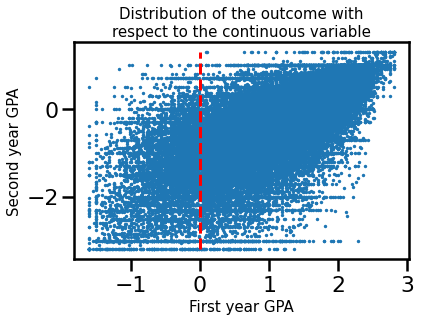

In [ ]:
#Points
plt.scatter(x=df.dist_from_cut_year1, y=df.dist_from_cut_year2, s = 2)
#Vertical line
plt.vlines(x = 0, ymin = min(df.dist_from_cut_year2), ymax = max(df.dist_from_cut_year2), color = "red", linestyles = 'dashed')
#Pimp the plot
plt.title("Distribution of the outcome with\nrespect to the continuous variable", fontsize=15)
plt.xlabel("First year GPA", fontsize=15)
plt.ylabel("Second year GPA", fontsize=15)

**Answer**

Data is very noisy, we cannot see much (except that there seems to exist a positive correlation between the GPA of the first year and the GPA of the second year).

### 2. Let's try to summarise the data to have a clearer overview. Instead of plotting all individual points, we cut the first year GPA into 100 intervals and aggregate all points inside the intervals into a single point whose second year GPA value is the mean for all units inside the interval.

In [ ]:
# First, we create 100 intervals of same width, starting from the minimum of the first year GPA and ending at the maximum of the second year GPA.
intervals = np.linspace(start = min(df.dist_from_cut_year1),
                        stop = max(df.dist_from_cut_year1),
                        num = 100)

# The label of each interval is the middle point of each interval 
labels = (intervals[1:] + intervals[:(len(intervals)-1)])/2 #Middle points

# We assign each point to the good interval
df = df.assign(closest_point = pd.cut(df.dist_from_cut_year1, 
                                     bins = intervals,
                                     labels = labels))

# Group by closest point and take the mean of the second year GPA
df_agg = df.groupby('closest_point').agg({'dist_from_cut_year2': 'mean',
                                          'closest_point' : 'first'}).reset_index(0, drop=True)

#Check the results
df_agg.head()

,dist_from_cut_year2,closest_point
0,-1.200000,-1.577778
1,-2.665000,-1.533333
2,-2.156566,-1.488889
3,-2.321765,-1.444444
4,-2.224737,-1.400000


### 3. Re-run your code of question 1 on the aggregated dataset. What do you see now? 

Text(0, 0.5, 'Second year GPA')

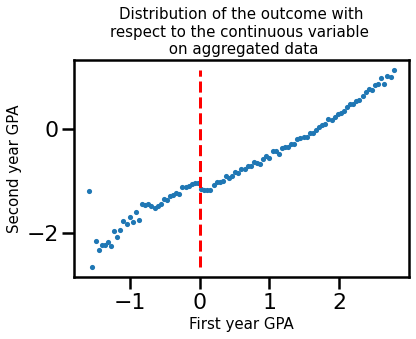

In [ ]:
#Points
plt.scatter(x=df_agg.closest_point, y=df_agg.dist_from_cut_year2, s = 10)
#Vertical line
plt.vlines(x = 0,
           ymin = min(df_agg.dist_from_cut_year2),
           ymax = max(df_agg.dist_from_cut_year2),
           color = "red",
           linestyles = 'dashed')
#Pim the plot
plt.title("Distribution of the outcome with\nrespect to the continuous variable \n on aggregated data", fontsize=15)
plt.xlabel("First year GPA", fontsize=15)
plt.ylabel("Second year GPA", fontsize=15)

**Asnwer**

We now observe a clear discontinuity in the outcome at the cut-off value.

# Exercise 3 : A very simple non-parametric estimate

In this exercice, we will implement a very simple non-parametric method to estimate to Local Average Treatment Effect (LATE) at the discontinuity point. It consists in restricting the dataset to the points close to the cut-off value, and compute the difference-in-means among treated and untreated patients.

### 1. Fill the LATE function to compute the difference in means around the discontinuity point

In [ ]:
##The function late_estimate computes the difference in means around the discontinuity point.
##df : the dataframe
##largest_diff : the maximum authorized distance to the cut-off point

def late_estimate(df, largest_diff):
    
    #Restrict the dataset to points within the distance threshold (lower or equal)
    df_close = df[abs(df.dist_from_cut_year1) <= largest_diff]
    print(f"The length of the filtered dataset is {df_close.shape[0]}.")
    
    #Mean in the treated
    mean_treated = np.mean(df_close.dist_from_cut_year2[df_close.probation_year1 == 1])
    
    #Mean in the control
    mean_control = np.mean(df_close.dist_from_cut_year2[df_close.probation_year1 == 0])    
    
    #Local ATE estimate
    late = mean_treated - mean_control
    return(late)


### 2. Manually test your function for difference value of the distance threshold. What do you see? 

In [ ]:
largest_diff = 0.02
late = late_estimate(df, largest_diff)
print(f"LATE estimate is {late.round(3)}.")

The length of the filtered dataset is 326.
LATE estimate is 0.204.


**Answer** 

The larger the threshold the larger the number of units included in the dataset; the lower the variance of the estimate, but the higher the bias. When considering threshold below 0.025, we seem to obtain a value close to 0.20-0.25 for the LATE. It suggests that on average putting the students into probation increases next year GPA.

# Exercise 4 : Local linear regression

In this exercice we will implement the local linear regression algorithm that we saw in class (using a single regression with an interaction term).

### 1. Fill the local_linear_estimator function.

In [ ]:
## The function local_linear_estimator :
## 1. Fits a linear model regressing the outcome on the treatment, the running variable, and the interaction 
# between the treatment and the running variable on a given dataset df.
## 2. Plots the output of the model on the aggregated dataset
## 3. Returns the coefficient for the treatment in the linear regression, and its confidence interval.

## df : the dataframe
## df_agg : the aggregated dataframe (for the plot)
## threshold : the value of threshold (to add vertical dotted lines suggesting the bandwidth on the plot). If None (default): no dotted line is plotted.
## plot : binary indicator whether the function should display the plot or not. Default is true.

def local_linear_estimator(df,df_agg, threshold = None, plot = True):
       
    #Linear model
    model = smf.wls("dist_from_cut_year2~dist_from_cut_year1*probation_year1", df)
    model_fit = model.fit()

    if(plot):
        #Prepare aggregated data by adding the value of the model.
        df_agg.closest_point = df_agg.closest_point.astype('float')
        df_agg = df_agg.assign(probation_year1= np.where(df_agg.closest_point < 0, 1, 0))
        df_agg = df_agg.assign(dist_from_cut_year1 = df_agg.closest_point)
        df_agg = df_agg.assign(model_prediction = model_fit.predict(df_agg))

        #Plot
        plt.scatter(x = df_agg.closest_point, y= df_agg.dist_from_cut_year2)
        plt.scatter(x = df_agg.closest_point, y= df_agg.model_prediction, color = "red", s =10)
        #Add line to show bandwidth
        if(threshold):
          plt.vlines(x = -threshold, ymin = min(df_agg.dist_from_cut_year2), ymax = max(df_agg.dist_from_cut_year2), color = "red", linestyles = 'dashed')
          plt.vlines(x = +threshold, ymin = min(df_agg.dist_from_cut_year2), ymax = max(df_agg.dist_from_cut_year2), color = "red", linestyles = 'dashed')

    #Extract value of the coefficient and the confidence interval
    coeff = model_fit.params['probation_year1']
    ci_low = model_fit.conf_int()[0]['probation_year1']
    ci_high = model_fit.conf_int()[1]['probation_year1']

    return(coeff, ci_low, ci_high)

### 2. Run your function on the whole dataset. What do you conclude?

Estimate for LATE : 0.317; CI = [0.284,0.35]


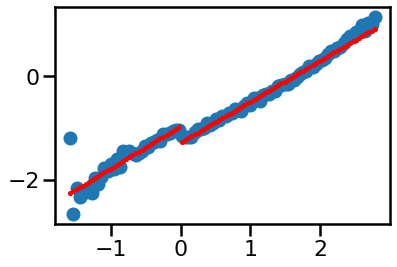

In [ ]:
estimate = local_linear_estimator(df,df_agg, plot = True)
print(f"Estimate for LATE : {estimate[0].round(3)}; CI = [{estimate[1].round(3)},{estimate[2].round(3)}]")

**Answer** 

The model seems to fit properly the data for the points close to the discontinuity (but not much for further points).
We get an estimate for LATE of 0.317, significant at 5\% threshold (CI does not contain zero).

### 3. Manually test your function on the dataset restricted to the points closer to the discontinuity cut-off. What are your impressions?

(0.16838316952477603, -0.012323784658576697, 0.34909012370812875)

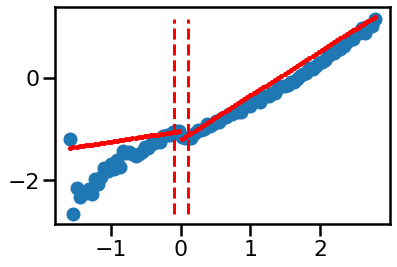

In [ ]:
#Test for several thresholds of your choice
threshold = 0.1

df2 = df[abs(df.dist_from_cut_year1) < threshold]
local_linear_estimator(df2,df_agg,threshold, plot = True)

**Answer**

If we use a large threshold, we get a robust model, but whose difference at the cut-off point may not reflect the local behavior around the discontinuity point, and bias the estimate if there is some treatment heterogeneity). If we use a small threshold, our model is fitted on a small number of points and may not be robust (indeed we observe some diverging effects, you can try threshold = 0.01; 0.02; 0.03 for instance).

### 4. Collect the LATE estimate, and confidence interval boundaries for several threshold values and plot the estimate and the confidence interval with respect to the threshold. What do you see?

In [ ]:
#Set a list of thresholds
threshold_to_test = np.linspace(0.01, 0.5, 50)

#Create empty arrays to store the values of LATE estimate, lower boundary of confidence interval
#and upper boundary of confidence interval.
late_tot = []
conf_low_tot = []
conf_high_tot = []

#Run your function to estimate LATE and CI for all thresholds 
for threshold in threshold_to_test:
    #Restrict dataset
    df2 = df[abs(df.dist_from_cut_year1) < threshold]
    #Run the function
    res = local_linear_estimator(df2,df_agg, plot = False)
    #Store the results
    late_tot.append(res[0])
    conf_low_tot.append(res[1])
    conf_high_tot.append(res[2])

Text(0, 0.5, 'LATE estimate')

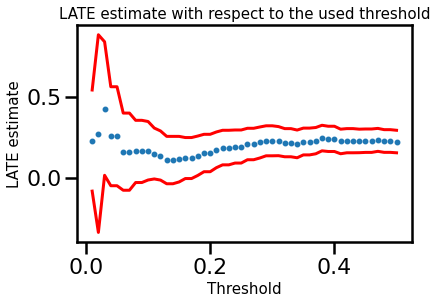

In [ ]:
#Plot LATE with respect to threshold (scatter plot)
#Frame your LATE estimate with two lines : one for the lower boundary of the confidence interval and
#one for the upper boundary of the confidence interval.

plt.scatter(threshold_to_test,late_tot, s =15)
plt.plot(threshold_to_test, conf_low_tot, color = 'red')
plt.plot(threshold_to_test, conf_high_tot, color = 'red')
plt.title("LATE estimate with respect to the used threshold", fontsize = 15)
plt.xlabel("Threshold", fontsize = 15)
plt.ylabel("LATE estimate", fontsize = 15)

**Answer**

This plot is a very good illustration of the bias-variance trade-off! For small thresholds, the width of the confidence interval is large (the estimate is even non-significantly greater than zero). The confidence interval width gets smaller and smaller with the threshold increasing. Yet, for high thresholds, the estimate may be biased. 